# Testing Pretrained Model - Mobilenet

## Reading Test Set

In [1]:
import pandas as pd

In [2]:
test_set = pd.read_pickle('subset/test_set.pkl')

# Image Preprocessing & Modeling

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_location = 'data/images'
all_labels = all_labels = ['Atelectasis',
                           'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema',
                           'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
                           'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
idg = ImageDataGenerator(rescale=1./255.,
                         samplewise_center=True,
                         samplewise_std_normalization=True)

test_generator = idg.flow_from_dataframe(
    dataframe=test_set,
    directory=img_location,
    x_col="imgindex",
    y_col=all_labels,
    classes=all_labels,
    target_size=(128, 128),
    seed=42,
    class_mode='raw',
    color_mode='rgb',
    batch_size=32,
    shuffle=False)

x_test, y_test = next(test_generator)

/usr/local/lib/python3.5/dist-packages/keras_preprocessing/image/dataframe_iterator.py:211: UserWarning: `classes` will be ignored given the class_mode="raw"
  .format(self.class_mode))


Found 23011 validated image filenames.


### Checking generated x-rays

**image_check** function visualizes the first 32 images of the input training images

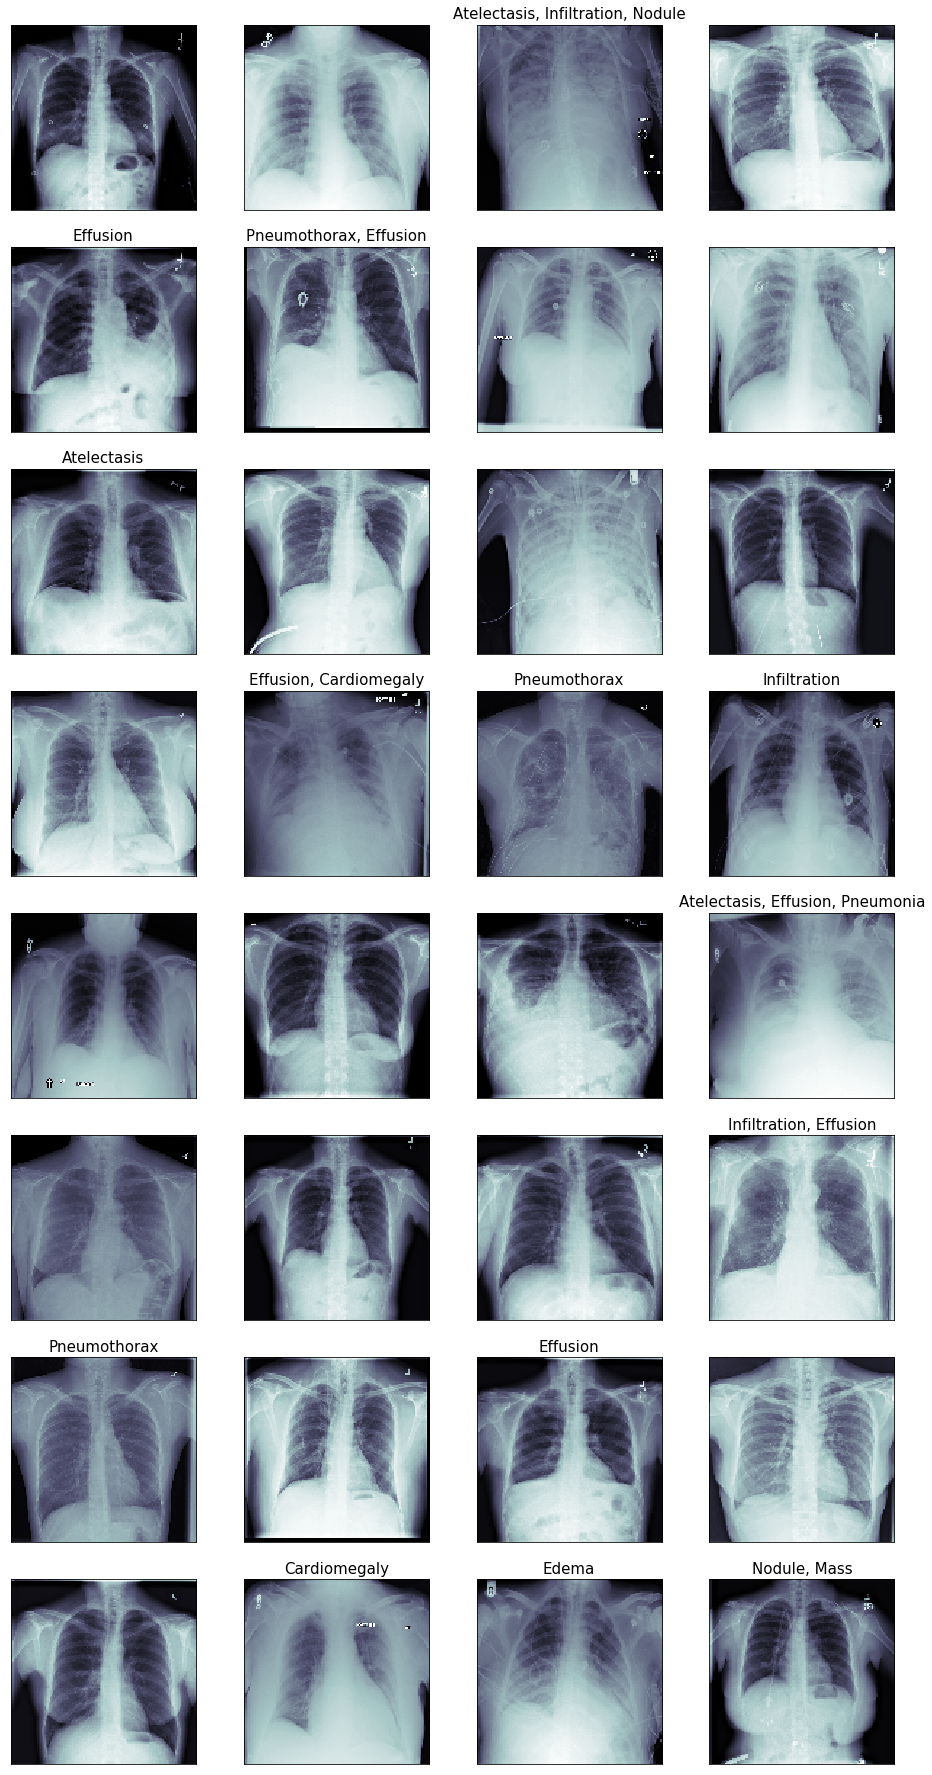

In [4]:
from visualizations import image_check
image_check(x_test, y_test, all_labels)

### Mobilenet Model Load

In [5]:
from tensorflow.keras.models import load_model
model = load_model('cnnmodels/mobilenet_model.h5')

## Test Results

In [6]:
results_test = model.evaluate_generator(test_generator, verbose=1)

720/720 [==============================] - 341s 473ms/step - loss: 0.1443 - categorical_accuracy: 0.2205 - auc: 0.8597


In [7]:
print('Test Loss:', results_test[0])
print('Test Categorical Accuray:', results_test[1])
print('Test AUC:', results_test[2])

Test Loss: 0.14430599761609403
Test Categorical Accuray: 0.22045977
Test AUC: 0.8597


## Analyzing Predictions

In [8]:
pred_y = model.predict_generator(test_generator, verbose = 1)

720/720 [==============================] - 335s 465ms/step


Text(0, 0.5, 'True Positive Rate')

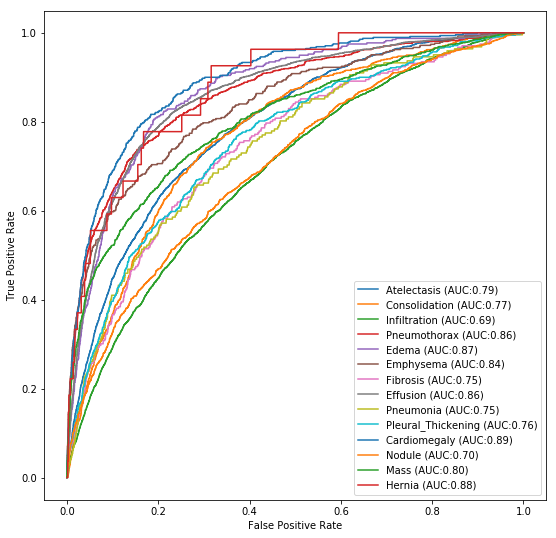

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_generator.labels[:,idx].astype(int), pred_y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

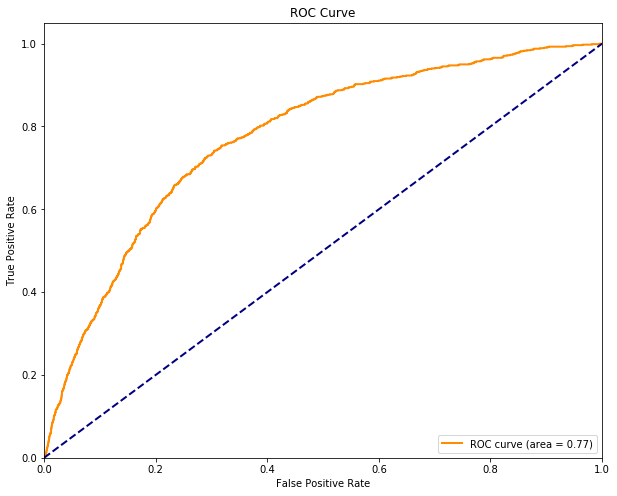

In [10]:
from sklearn.metrics import roc_curve,auc
fpr      = dict()
tpr      = dict()
roc_auc  = dict()

for i in range(14):
       fpr[i], tpr[i], _ = roc_curve(test_generator.labels[:,i], pred_y[:, i])
       roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(test_generator.labels.ravel(), pred_y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure(figsize = (10,8))
lw = 2
plt.plot(fpr[1],tpr[1],color = 'darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' %roc_auc[1])
plt.plot([0,1],[0,1],color = 'navy',lw = lw, linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = 'lower right')
plt.show()

In [11]:
test_generator.samples

23011

In [12]:
test_generator = idg.flow_from_dataframe(
    dataframe=test_set,
    directory=img_location,
    x_col="imgindex",
    y_col=all_labels,
    classes=all_labels,
    target_size=(128, 128),
    seed=42,
    class_mode='raw',
    color_mode='rgb',
    batch_size=23011) #getting al the samples

x_test, y_test = next(test_generator)

/usr/local/lib/python3.5/dist-packages/keras_preprocessing/image/dataframe_iterator.py:211: UserWarning:

`classes` will be ignored given the class_mode="raw"



Found 23011 validated image filenames.


In [13]:
pred_y = model.predict(x_test)

In [14]:
import numpy as np
import pandas as pd
import os

if not os.path.exists('test_results'):
    os.makedirs('test_results')
results = {'label':[], 'pdx_mobilenet':[], 'dx':[]}
for label, pred_count, test_count in zip(all_labels, 
                                     100*np.mean(pred_y,0), 
                                     100*np.mean(y_test,0)):
    results['label'].append(label)
    results['pdx_mobilenet'].append(pred_count)
    results['dx'].append(test_count)
    pd.DataFrame(results).sort_values('label').to_csv('test_results/test_results_mobilenet.csv', 
                                                      index=False, columns = ['label', 'dx', 'pdx_base'])
    print('===========================================\n',
          '%s: Diagnosis: %2.2f%%, PDx: %2.2f%%' % (label, test_count, pred_count))

 Atelectasis: Diagnosis: 9.75%, PDx: 8.61%
 Consolidation: Diagnosis: 3.55%, PDx: 2.77%
 Infiltration: Diagnosis: 17.17%, PDx: 16.51%
 Pneumothorax: Diagnosis: 4.26%, PDx: 2.86%
 Edema: Diagnosis: 1.73%, PDx: 1.22%
 Emphysema: Diagnosis: 1.85%, PDx: 1.00%
 Fibrosis: Diagnosis: 1.20%, PDx: 0.59%
 Effusion: Diagnosis: 11.12%, PDx: 12.36%
 Pneumonia: Diagnosis: 0.96%, PDx: 0.58%
 Pleural_Thickening: Diagnosis: 2.43%, PDx: 2.25%
 Cardiomegaly: Diagnosis: 2.09%, PDx: 2.81%
 Nodule: Diagnosis: 5.08%, PDx: 3.51%
 Mass: Diagnosis: 4.48%, PDx: 3.29%
 Hernia: Diagnosis: 0.12%, PDx: 0.08%


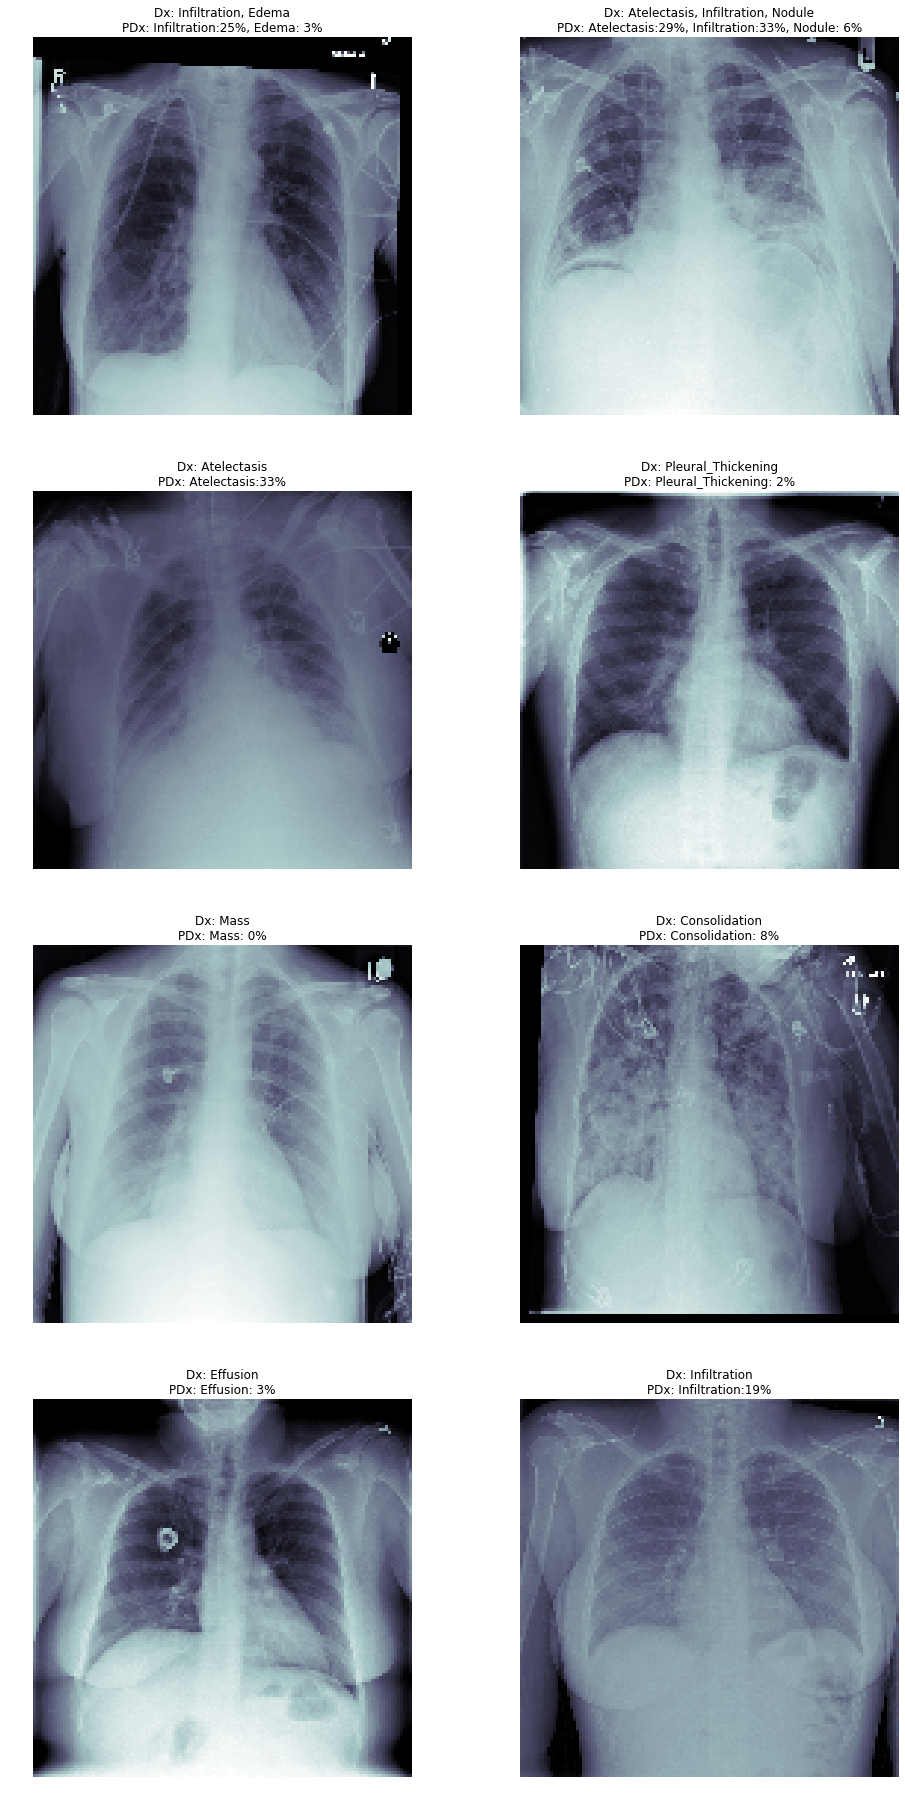

In [16]:
sickest_idx = np.argsort(np.sum(y_test, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(x_test[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class for n_class, n_score in zip(all_labels, y_test[idx]) if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class, p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  y_test[idx], pred_y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')